
# Multi-currency market making (FX) — closed-form approximation + Riccati ODE

This notebook implements the scalable approximation described in:

**Alexander Barzykin, Philippe Bergault, Olivier Guéant (2023)**  
*Dealing with multi-currency inventory risk in FX cash markets* (arXiv:2207.04100v4).

The key steps implemented below are:

1. **Logistic client-demand model** (intensity) and the associated **Hamiltonian**  
   $H^{n,i,j}(z,p)=\sup_\delta f^{n,i,j}(z,\delta)(\delta-p)$.
2. **Quadratic approximation** of the client Hamiltonians around \(p=0\):  
   $\check H(z,p)=\alpha_0(z)+\alpha_1(z)p+\tfrac12\alpha_2(z)p^2$.
3. Construction of the low-dimensional objects $M,\tilde M,P$ and the **matrix Riccati-like ODE** for $A(t)$ and $B(t)$ (Eq. (5) in the paper).
4. Approximate quotes $\check\delta$ (Eq. (2) with $\theta\to\check\theta$ and hedging rates $\check\xi$ (Eq. (3) with $\theta\to\check\theta$, as written on p.6 of the paper).

> **Design goals**
> - All model parameters live in one config section.
> - The main routine is wrapped as `run_multicurrency_mm(...)`.
> - Logic is split into small, testable functions.


In [ ]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt

from src import (
    BP, DAY_SECONDS,
    ModelParams, build_paper_example_params, restrict_currencies,
    logistic_f, optimal_delta_logistic, H_logistic,
    quadratic_coeffs_H_logistic,
    build_Sigma, build_M_tildeM_P, solve_AB_euler,
    optimal_client_markup, optimal_hedge_rate,
    MMResult, run_multicurrency_mm,
    simulate_inventory_path_tau_leap, autocorr,
    plot_top_of_book_quotes_vs_inventory, plot_hedge_rates_vs_inventory,
)

np.set_printoptions(precision=6, suppress=True)


## 1) Parameters / configuration

To experiment with **fewer currencies**, either:
- build `ModelParams` with a smaller `currencies` list, and include only the matching pairs in `pairs`, **or**
- build the full model, then call `restrict_currencies(...)`.

The example builder `build_paper_example_params()` matches **Table 1** of the paper (p.7) for:
USD, EUR, JPY, GBP, CHF with 2 tiers and size ladder \(z=\{1,5,10,20,50\}\) M$.



## 2) Logistic intensity + optimal quotes

For each tier and currency-pair direction \((i,j)\), the paper uses:

$\Lambda(z,\delta)=\lambda(z)\,f(z,\delta),\qquad
f(z,\delta)=\frac{1}{1+\exp(\alpha(z)+\beta(z)\delta)}.$

The key object for pricing is the Hamiltonian (Eq. (1)):

$H(z,p)=\sup_\delta f(z,\delta)\,(\delta-p).$

The optimal quote \(\bar\delta(z,p)\) is the argmax in that supremum.
The paper notes that in the logistic case \(\bar\delta\) is easy to compute numerically (p.5).
Below we use a **robust bracket + bisection** method (no fragile Newton steps).



## 3) Quadratic approximation coefficients \(\alpha_0,\alpha_1,\alpha_2\)

The approximation (p.5) is:

$\check H(z,p)=\alpha_0(z)+\alpha_1(z)p+\tfrac12\alpha_2(z)p^2$

with the “natural choice”:

$\alpha_0(z)=H(z,0),\qquad \alpha_1(z)=\partial_p H(z,0),\qquad \alpha_2(z)=\partial_{pp}^2 H(z,0).$


For numerical stability:
- We use the envelope theorem: $\partial_p H(z,p)=-f(\bar\delta(z,p))$.
- Then $\alpha_2$ can be approximated by a centered finite difference of $\partial_p H$ around 0.

Because the paper's example uses **discrete sizes** $z\in\{1,5,10,20,50\}$ M$ (Table 1, p.7),
we implement sums instead of integrals.



## 4) Build $\Sigma$, $M$, $\tilde M$, $P$ and solve the Riccati-like ODE (Eq. (5))

### 4.1 Covariance \(\Sigma\)

The paper uses $\Sigma=(\rho_{i,j}\sigma_i\sigma_j)$ (p.4), where:
- $\sigma_i$ is the volatility of currency $i$ vs the reference currency (here USD),
- $\rho_{i,j}$ is the correlation between those returns.

### 4.2 Discrete-size versions of $M,\tilde M,P$

The paper defines (p.6) matrices (here implemented as **sums over sizes**):

$M_{i,j}=\sum_{n}\sum_z \alpha^{n,i,j}_2(z)\,z\,\lambda^{n,i,j}(z),
\quad
\tilde M_{i,j}=\sum_{n}\sum_z \alpha^{n,i,j}_1(z)\,z\,\lambda^{n,i,j}(z),$

$P_{i,j}=\sum_{n}\sum_z \alpha^{n,i,j}_2(z)\,z^2\,\lambda^{n,i,j}(z).$

### 4.3 The ODE

We implement Eq. (5) as written in the paper, and integrate **backward** from $t=T$ to $t=0$ using an explicit Euler scheme.

> Practical note: for the paper parameters and \(T=0.05\) days, Euler with a few thousand steps is stable when the units are handled consistently (bps converted to decimals).


## 5) Policy functions: quotes and hedging rates

### 5.1 Quotes (p.6, just above "Numerical results and discussion")

Using $A(t),B(t)$, the paper writes (p.6):

$\check\delta_{n,i,j}(t,z)=\bar\delta_{n,i,j}\!\left(z,\ \Big((2Y_{t^-}+z(e^i-e^j))^\top A(t)+B(t)^\top\Big)(e^i-e^j)\right).$

We implement the scalar:

$p_{n,i,j}(t,z,Y)=\Big((2Y+z(e^i-e^j))^\top A+B^\top\Big)(e^i-e^j),$

then call `optimal_delta_logistic(p, alpha, beta)`.

### 5.2 Hedging (Eq. (3) with $\theta\to\hat\theta$)

From Eq. (3) with $\hat\theta(t,y)=-y^\top A(t)y - y^\top B(t) - C(t)$
and $\partial_{y^i}\hat\theta = -(2A(t)y+B(t))_i$:

$\check\xi^{i,j}_t = \mathcal{H}^{i,j\,\prime}\!\left(
-(2A(t)Y_{t^-}+B(t))^\top(e^i-e^j)
+ k^iY^i_{t^-}\big(1-(2A(t)Y_{t^-}+B(t))^\top e^i\big)
- k^jY^j_{t^-}\big(1-(2A(t)Y_{t^-}+B(t))^\top e^j\big)
\right).$

We implement $\mathcal{H}^{i,j\,\prime}(p)$ for the D2D execution cost
$L(\xi)=\psi|\xi|+\eta|\xi|^2$:

$\mathcal{H}^{i,j\,\prime}(p)=\begin{cases}
0 & |p|\le \psi \\
\frac{p-\psi\,\mathrm{sign}(p)}{2\eta} & |p|>\psi.
\end{cases}$

> **Note on the paper's p.6 shorthand**: The approximate hedging formula written on p.6 of the paper
> uses $(A(t)Y+B(t))$ instead of $(2A(t)Y+B(t))$. This appears to be a typo—it is inconsistent
> with Eq. (3) and $\partial_{y^i}\hat\theta = -(2Ay+B)_i$. The implementation here uses the
> correct factor of 2, consistent with the quote formula and the stated form of $\hat\theta$.

> Units:
> - inventories $Y$ and sizes $z$ are in **M$**,
> - time is in **days**,
> - costs and markups are in **decimals**.
>   For plotting in bps, multiply by $10^4$.

## 6) Main wrapper: `run_multicurrency_mm(...)`

The main entry point is `run_multicurrency_mm(mp)` (defined in `src/policy.py`):
- builds $\Sigma, M, \tilde M, P$
- solves for $A(0),B(0)$
- returns an `MMResult` object with helper methods `.markup()` and `.hedge_rate()`.


## 7) Reproduce key plots from the paper (Figures 1 and 2)

### Figure 1 (p.7): top-of-book pricing vs GBP inventory

The paper plots, for tier 1 and size 1M$:
- GBPUSD
- EURUSD
- EURGBP  
as functions of **GBP inventory**, with all other inventories set to 0.

Their caption indicates they plot:
- \( \delta_{1,X,Y} \) and \( -\delta_{1,Y,X} \) for each pair \(XY\).

Below we implement a helper that, given an FX pair name `XY`, interprets:
- **bid curve** = \( \delta_{X,Y} \) (dealer sells Y, receives X)
- **ask curve** = \(-\delta_{Y,X}\) (dealer sells X, receives Y, shown with a minus sign)

This matches how bid/ask are displayed around 0 in their figure.



### Figure 2 (p.8): optimal externalization / hedging rates vs EUR inventory

The paper shows hedging rates for many pairs as a function of **EUR inventory** (others = 0).
Below we compute \(\check\xi\) for each pair and plot in **M$/s** for comparability with the paper's axis label.



## 8) Run the paper example

This cell:
- builds the Table 1 parameter set,
- solves the Riccati ODE,
- reproduces plots similar to Figures 1 and 2.


In [11]:

# --- Build the paper's example (Table 1) and solve ---
mp = build_paper_example_params()

# If you want fewer currencies, uncomment e.g.:
# mp = restrict_currencies(mp, ["USD", "EUR", "GBP"])

res = run_multicurrency_mm(mp, eps_p=1e-8, n_steps=2000)

print("Currencies:", res.mp.currencies)
print("Max |A0|:", np.max(np.abs(res.A0)))
print("Max |B0|:", np.max(np.abs(res.B0)))


Currencies: ['USD', 'EUR', 'JPY', 'GBP', 'CHF']
Max |A0|: 1.2816429063384334e-06
Max |B0|: 0.0


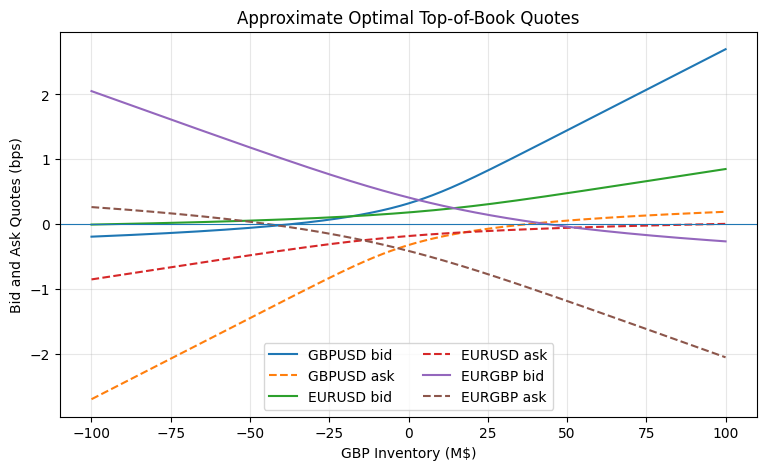

In [12]:

# --- Figure 1 style plot (p.7) ---
inv_grid = np.linspace(-100, 100, 401)  # M$
plot_top_of_book_quotes_vs_inventory(
    res=res,
    tier_idx=0,            # tier 1
    z_musd=1.0,            # 1M$ top of book
    inventory_ccy="GBP",
    inventory_grid_musd=inv_grid,
    pairs_to_plot=[("GBP", "USD"), ("EUR", "USD"), ("EUR", "GBP")],
)


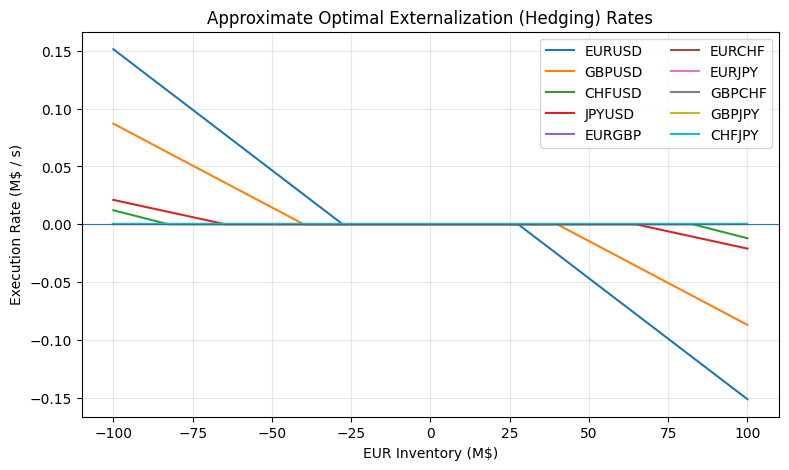

In [13]:

# --- Figure 2 style plot (p.8) ---
inv_grid = np.linspace(-100, 100, 401)  # M$

# We choose a representative list of ordered directions (buy, sell).
# You can add/remove pairs freely.
ordered_pairs = [
    ("EUR", "USD"), ("GBP", "USD"), ("CHF", "USD"), ("JPY", "USD"),
    ("EUR", "GBP"), ("EUR", "CHF"), ("EUR", "JPY"),
    ("GBP", "CHF"), ("GBP", "JPY"),
    ("CHF", "JPY"),
]

plot_hedge_rates_vs_inventory(
    res=res,
    inventory_ccy="EUR",
    inventory_grid_musd=inv_grid,
    ordered_pairs_to_plot=ordered_pairs,
)



## 9) Notes / sanity checks

A few useful diagnostics you can run:

- Check \(\Sigma\succeq 0\) (PSD).
- Inspect whether \(A_0\) is PSD (often it is, numerically).
- Check that \(B_0\approx 0\) for symmetric parameter sets (as in Table 1).

You can also increase `n_steps` if you suspect Euler discretization error.


In [14]:

# --- Optional diagnostics ---
eig_Sigma = np.linalg.eigvalsh(res.Sigma)
eig_A0 = np.linalg.eigvalsh(res.A0)

print("Sigma eigenvalues (min/max):", eig_Sigma.min(), eig_Sigma.max())
print("A0 eigenvalues (min/max):   ", eig_A0.min(), eig_A0.max())
print("B0:", res.B0)


Sigma eigenvalues (min/max): 0.0 0.00010780568270513368
A0 eigenvalues (min/max):    0.0 1.791548641144156e-06
B0: [0. 0. 0. 0. 0.]



## 10) (Optional) Skeleton for Monte Carlo simulation

The paper also shows Monte Carlo-based inventory distributions and autocorrelations (Figures 4–5).
Implementing a faithful simulator requires careful treatment of:
- the discrete-size Poisson flows per tier and per direction,
- inventory updates \(Y\leftarrow Y \pm z\),
- hedging as continuous controls \(\xi(t)\),
- and (optionally) the price-driven diffusion of \(Y\) via \(S\).

Below is a **minimal, modular skeleton** you can extend.  
It uses a *tau-leaping* Poisson approximation at each time step `dt_sec`.



Example usage (short run for speed):

> To approach Figures 4–5 in the paper, you need long runs (millions of seconds) and careful tuning of dt.


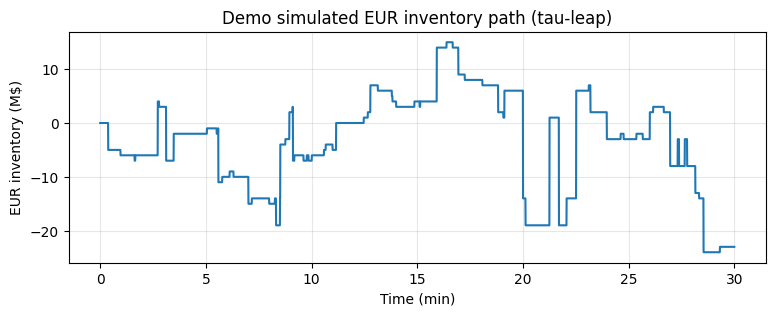

In [16]:

# --- quick demo simulation (keep short unless you have time) ---
T_demo_sec = 60.0 * 30.0   # 30 minutes
dt_sec = 0.25              # 250 ms

times, Ypath = simulate_inventory_path_tau_leap(
    res,
    T_sec=T_demo_sec,
    dt_sec=dt_sec,
    seed=42,
    include_hedging=True,
)

# Plot EUR inventory path as a sanity check
eur_idx = res.mp.currencies.index("EUR")
plt.figure(figsize=(9, 3))
plt.plot(times/60.0, Ypath[:, eur_idx])
plt.xlabel("Time (min)")
plt.ylabel("EUR inventory (M$)")
plt.title("Demo simulated EUR inventory path (tau-leap)")
plt.grid(True, alpha=0.3)
plt.show()
